# **Deteksi Jerawat Pada Wajah dengan menggunakan model CNN (Convolutional Neural Network)**

1. Import Library

In [1]:
import tensorflow as tf
import os
import random
from sklearn.metrics import f1_score
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB1
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall
import numpy as np
from io import BytesIO
# Plotting and dealing with images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# from ipywidgets import widgets
from PIL import Image

2. Import Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

TRAIN_DIR = '/content/drive/MyDrive/Deep Learning/Acne Dataset/train'
VAL_DIR = '/content/drive/MyDrive/Deep Learning/Acne Dataset/valid'
TEST_DIR = '/content/drive/MyDrive/Deep Learning/Acne Dataset/test'

print("Train:", len(os.listdir(TRAIN_DIR)))
print("Valid:", len(os.listdir(VAL_DIR)))
print("Test:", len(os.listdir(TEST_DIR)))

Mounted at /content/drive
Train: 6
Valid: 6
Test: 6


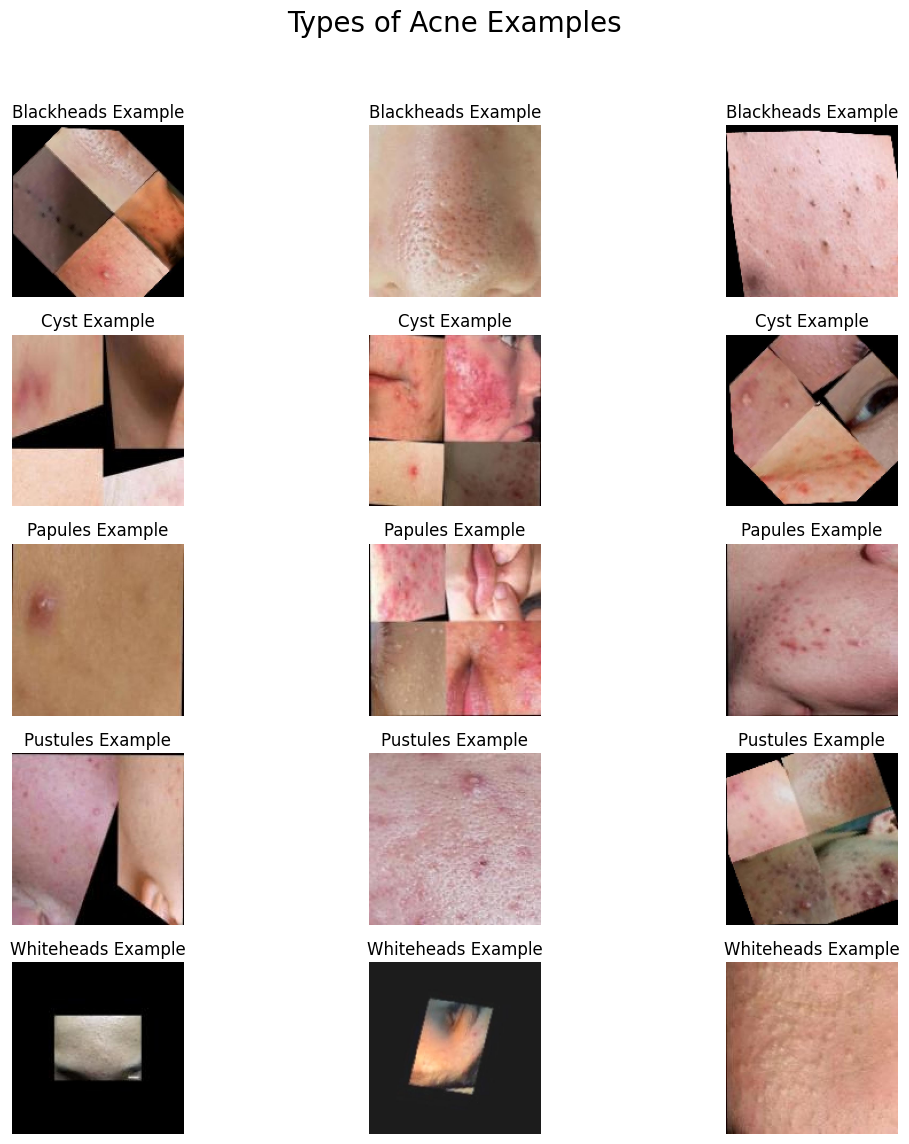

In [3]:
categories = ['Blackheads', 'Cyst', 'Papules', 'Pustules', 'Whiteheads']

fig, axes = plt.subplots(len(categories), 3 , figsize=(12, 12))
plt.suptitle("Types of Acne Examples", fontsize=20)

for i, category in enumerate(categories):
  category_path = os.path.join(TRAIN_DIR, category)
  images = os.listdir(category_path)[:3]
  for j, img_name in enumerate(images):
    img_path = os.path.join(category_path, img_name)
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(150, 150))
    axes[i, j].imshow(img)
    axes[i, j].set_title(f'{category} Example')
    axes[i, j].axis("off")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [4]:
sample_array = tf.keras.preprocessing.image.img_to_array(img)
print(f"Each image has shape{sample_array.shape}")

Each image has shape(150, 150, 3)


3. Optimasi

In [5]:
def train_val_test_dataset():
  """
  Create train, validation, and test datasets.

  Returns:
  (tf.data.Dataset, tf.data.Dataset, tf.data.Dataset): train, validation, and test datasets
  """
  # Load train and validation directories
  train_dataset = tf.keras.utils.image_dataset_from_directory(
      directory=TRAIN_DIR,
      batch_size=32,
      image_size=(150, 150),
      label_mode="categorical",
      shuffle=True
  )
  # Load entire validation dataset from VAL_DIR
  val_dataset = tf.keras.utils.image_dataset_from_directory(
      directory=VAL_DIR,
      batch_size=32,
      image_size=(150, 150),
      label_mode="categorical",
  )
  # Load entire validation dataset from TEST_DIR
  test_dataset = tf.keras.utils.image_dataset_from_directory(
      directory=TEST_DIR,
      batch_size=32,
      image_size=(150, 150),
      label_mode="categorical",
  )

  # Mengoptimalkan proses training, validasi, dan training
  train_dataset = train_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
  val_dataset = val_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
  test_dataset = test_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

  return train_dataset, val_dataset, test_dataset

In [6]:
train_dataset, val_dataset, test_dataset = train_val_test_dataset()
print(f"Images of train dataset have shape: {train_dataset.element_spec[0].shape}")
print(f"Labels of train dataset have shape: {train_dataset.element_spec[1].shape}")
print(f"Images of validation dataset have shape: {val_dataset.element_spec[0].shape}")
print(f"Labels of validation dataset have shape: {test_dataset.element_spec[1].shape}")

Found 2778 files belonging to 5 classes.
Found 921 files belonging to 5 classes.
Found 918 files belonging to 5 classes.
Images of train dataset have shape: (None, 150, 150, 3)
Labels of train dataset have shape: (None, 5)
Images of validation dataset have shape: (None, 150, 150, 3)
Labels of validation dataset have shape: (None, 5)


4. Inisialisasi Model CNN

In [7]:
data_augmentation = tf.keras.Sequential([
    # Modifikasi acak untuk meningkatkan variasi data
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2), # Subtler rotation
    layers.RandomZoom(height_factor=0.1), # Moderate Zoom
    layers.RandomBrightness(0.1), # Adjust brightness
    layers.RandomContrast(0.2), # Higher contrast adjustment
    layers.GaussianNoise(0.02), # Slightly increased noise

    # Mengubah ukuran gambar ke 150*150 piksel
    layers.Resizing(height=150, width=150) # Resize for EfficientNet
])

In [8]:
def create_efficientnet_model():
  """
  Creates a CNN model using EfficientNetB0 for transfer learning.

  Returns:
    A tf.keras.Model object.
  """
  efficientnet_model = tf.keras.applications.EfficientNetB0(
      include_top=False,
      weights="imagenet",
      input_shape=(150, 150, 3)
  )

  for layer in efficientnet_model.layers[:-50]:
    layer.trainable = True

    input_layer = layers.Input(shape=(150, 150, 3))
    x = data_augmentation(input_layer)
    x = efficientnet_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.6)(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.005))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    output_layer = layers.Dense(5, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.005))(x)

    model = Model(inputs=input_layer, outputs=output_layer)

    model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.0001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=True
    ),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
    )

    return model

In [9]:
# Panggil function create_efficientnet_model
model = create_efficientnet_model()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
# view summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 5, 5, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,894,824 (22.49 MB)

 Trainable params: 5,849,729 (22.31 MB)

 Non-trainable params: 45,095 (176.16 KB)

In [11]:
# check data architecture
example_batch_images, example_batch_labels = next(iter(train_dataset))

try:
  model.evaluate(example_batch_images, example_batch_labels, verbose=False)
except:
  print("Your model is not compatible with the dataset you defined earlier. Check that the loss function, last layer and label_mode are compatible with one another.")
else:
  predictions = model.predict(example_batch_images, verbose=False)
  print(f"predictions have shape: {predictions.shape}")

predictions have shape: (32, 5)


In [12]:
from sklearn.utils import class_weight

# Extract class labels from the dataset
class_labels = []
for images, labels in train_dataset:
    class_labels.append(np.argmax(labels, axis=1)) # Convert one-hot encoded labels to class indices

# Flatten the list of class labels
class_labels = np.concatenate(class_labels)

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_labels),
    y=class_labels
)

# Convert to dictionary for use in model.fit
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: np.float64(0.7559183673469387), 1: np.float64(0.8613953488372093), 2: np.float64(0.8946859903381642), 3: np.float64(0.9513698630136986), 4: np.float64(2.8787564766839377)}


In [13]:
lr_schedular = ReduceLROnPlateau(
    mobitor='val_accuracy',
    factor=0.8,
    patience=5,
    min_lr=1e-7,
    verbose=1
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True
)

# Add the callbacks to the fit function:
with tf.device('/GPU:0'):
  history = model.fit(
      train_dataset,
      epochs=20,
      validation_data=val_dataset,
      callbacks=[lr_schedular, early_stopping],
      class_weight=class_weights
  )

Epoch 1/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 617s 6s/step - accuracy: 0.2296 - loss: 6.0123 - precision: 0.2332 - recall: 0.1674 - val_accuracy: 0.3507 - val_loss: 4.8593 - val_precision: 0.7083 - val_recall: 0.0369 - learning_rate: 1.0000e-04
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 381s 4s/step - accuracy: 0.3271 - loss: 5.4364 - precision: 0.3412 - recall: 0.2624 - val_accuracy: 0.4647 - val_loss: 4.6737 - val_precision: 0.7170 - val_recall: 0.2421 - learning_rate: 1.0000e-04
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 379s 4s/step - accuracy: 0.3824 - loss: 5.0910 - precision: 0.4183 - recall: 0.3228 - val_accuracy: 0.5233 - val_loss: 4.5226 - val_precision: 0.6595 - val_recall: 0.3659 - learning_rate: 1.0000e-04
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 381s 4s/step - accuracy: 0.4358 - loss: 4.9056 - precision: 0.4778 - recall: 0.3846 - val_accuracy: 0.5179 - val_loss: 4.4773 - val_precision: 0.6318 - val_recall: 0.4191 - learning_rate: 1.0000e-04
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 387s 4s/step -

5. Evaluation

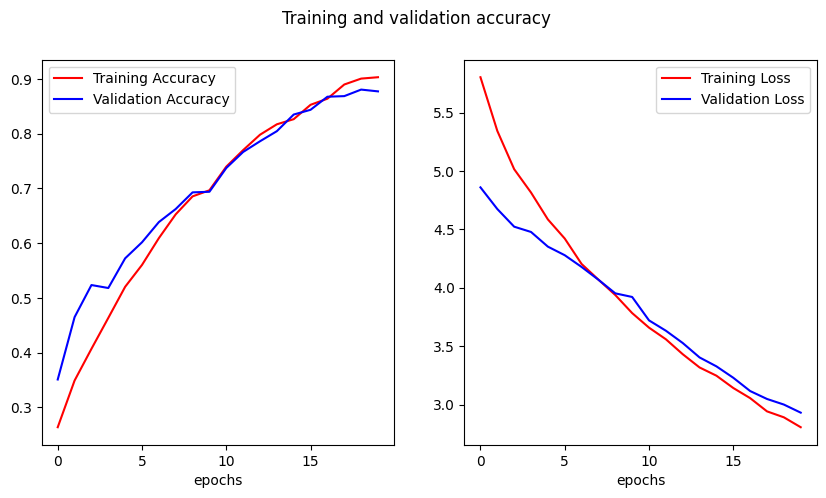

In [14]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
  ax[i].plot(epochs, data[0], 'r', label="Training " + label)
  ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
  ax[i].legend()
  ax[i].set_xlabel('epochs')

plt.show()

In [15]:
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss},\nTest Accuracy:: {test_accuracy},\nTest Precision: {test_precision},\nTest Recall:: {test_recall}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 137s 5s/step - accuracy: 0.9021 - loss: 2.8872 - precision: 0.9182 - recall: 0.8759
Test Loss: 2.9167490005493164,
Test Accuracy:: 0.8910675644874573,
Test Precision: 0.9067121744155884,
Test Recall:: 0.8681917190551758


29/29 ━━━━━━━━━━━━━━━━━━━━ 35s 903ms/step
Test Set F1 Score: 0.8924954952178791


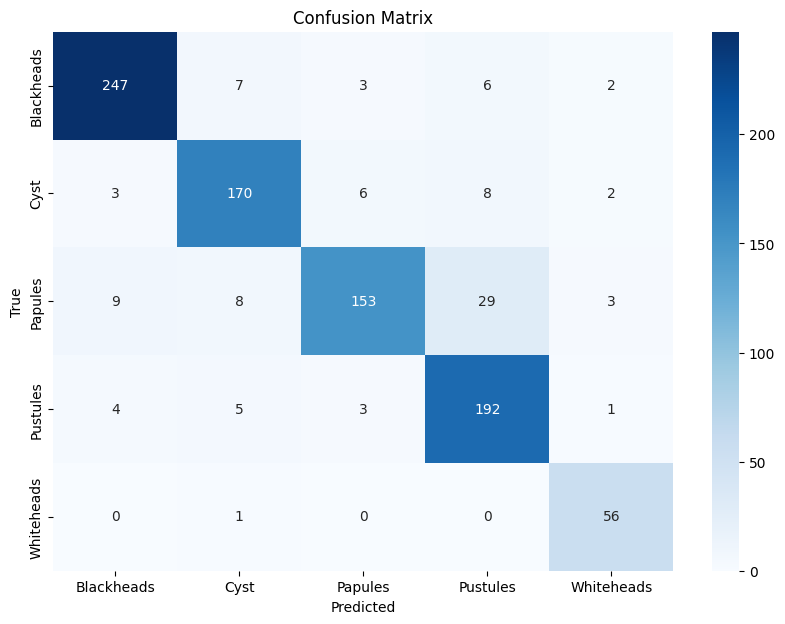

In [16]:
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Define categories
categories = categories

# Get predictions and true labels
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_pred = np.argmax(model.predict(test_dataset), axis=1)

# Calculate F1 score
f1 = f1_score(np.argmax(y_true, axis=1), y_pred, average='macro')
print(f"Test Set F1 Score: {f1}")

# Generate confusion matrix
cm = confusion_matrix(np.argmax(y_true, axis=1), y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

6. Testing

In [17]:
def predict_custom_image(image_path, model, categories):
  """
  Make predictions on a custom image, aligned with your training setup.

  Parameters:
  image_path (str): Path to the image file
  model: Trained EfficientNetB0-based model
  categories (list): List of category names

  Returns:
  tuple: (predicted_category, confidence_score, preprocessed_image)
  """
  try:
    # Load and preprocess the image
    img = Image.open(image_path)

    # Convert to RGB if needed
    if img.mode != 'RGB':
      img = img.convert('RGB')

    # Resize to match your training size (120*120)
    img = img.resize((150, 150))

    # Convert to array
    img_array = tf.keras.preprocessing.image.img_to_array(img)

    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)

    # Normalize pixel values (matching EfficientNetB0 preprocessing)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

    # Make prediction
    predictions = model.predict(img_array, verbose=0)

    # Get top 3 prediction for analysis
    top_3_indices = np.argsort(predictions[0])[-3:][::-1]
    print("\nTop 3 predictions:")
    for idx in top_3_indices:
      print(f"{categories[idx]}: {predictions[0][idx]:.2%}")

    predicted_class_index = np.argmax(predictions[0])
    confidence_score = float(predictions[0][predicted_class_index])

    return categories[predicted_class_index], confidence_score, img_array[0]

  except Exception as e:
    print(f"Error processing image: {str(e)}")

def display_prediction(image_path, model, categories):
  """
  Display the original image with its prediction and confidence score.
  """
  predicted_category, confidence_score, _ = predict_custom_image(image_path, model, categories)

  if predicted_category is not None:
    # Load and display original image
    img = Image.open(image_path)
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_category}\nConfidence: {confidence_score:.2%}",
              fontsize=12, pad=20)
    plt.show()

    # Print detailed analysis
    print(f"\nDetailed Analysis:")
    print(f"Predicted Category: {predicted_category}")
    print(f"Confidence Score: {confidence_score:.2%}")


Top 3 predictions:
Pustules: 90.18%
Cyst: 9.73%
Whiteheads: 0.06%


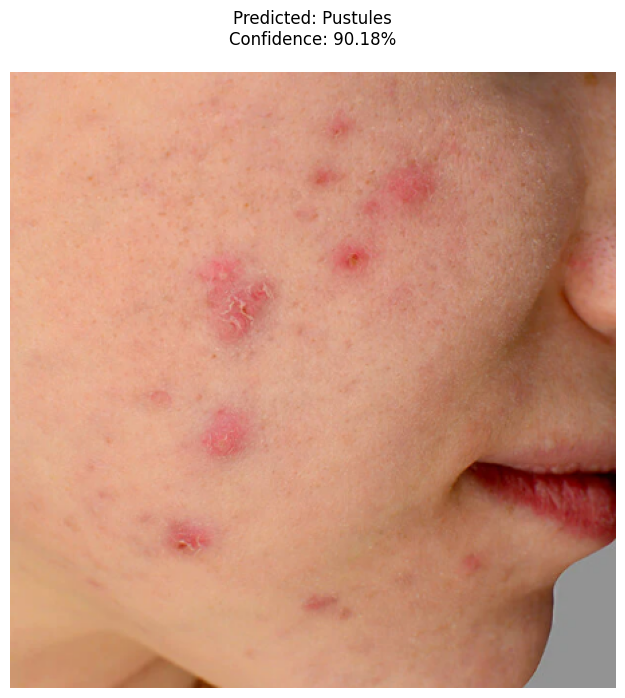


Detailed Analysis:
Predicted Category: Pustules
Confidence Score: 90.18%


In [28]:
# Example usage
image_path = "/content/drive/MyDrive/Deep Learning/google/Screenshot 2025-05-05 143014.png"
display_prediction(image_path, model, categories)


Top 3 predictions:
Blackheads: 68.12%
Cyst: 31.67%
Pustules: 0.17%


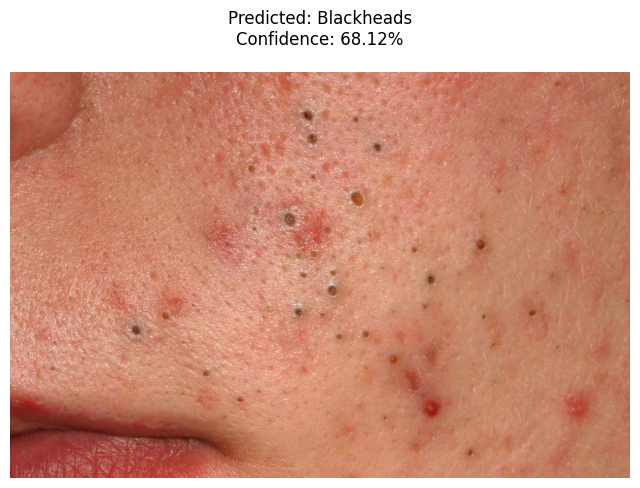


Detailed Analysis:
Predicted Category: Blackheads
Confidence Score: 68.12%


In [29]:
# Example usage
image_path = "/content/drive/MyDrive/Deep Learning/google/Screenshot 2025-05-05 143355.png"
display_prediction(image_path, model, categories)


Top 3 predictions:
Cyst: 99.94%
Pustules: 0.05%
Whiteheads: 0.01%


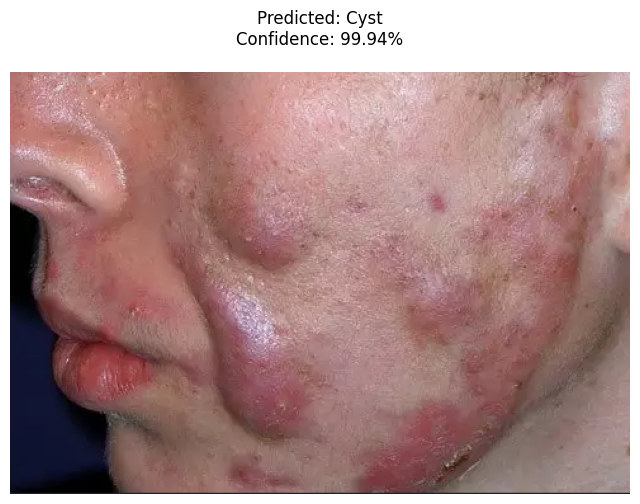


Detailed Analysis:
Predicted Category: Cyst
Confidence Score: 99.94%


In [30]:
# Example usage
image_path = "/content/drive/MyDrive/Deep Learning/google/Screenshot 2025-05-05 143208.png"
display_prediction(image_path, model, categories)


Top 3 predictions:
Pustules: 73.87%
Cyst: 15.17%
Blackheads: 10.12%


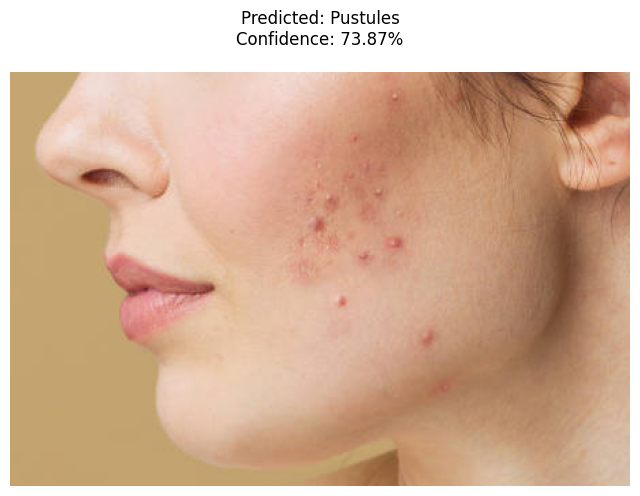


Detailed Analysis:
Predicted Category: Pustules
Confidence Score: 73.87%


In [31]:
# Example usage
image_path = "/content/drive/MyDrive/Deep Learning/google/Screenshot 2025-05-05 142817.png"
display_prediction(image_path, model, categories)